<a href="https://colab.research.google.com/github/ioana0901/Sentiment-Analysis-on-Short-Texts-The-Case-of-the-Romanian-Language/blob/main/Pretrained_Word2Vec_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install import_ipynb

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Analiza sentimentelor umane a textelor din Limba Română"

/content/drive/MyDrive/Analiza sentimentelor umane a textelor din Limba Română


In [ ]:
import import_ipynb
from FunctionsList import *
import pandas as pd
import numpy as np
import random
import gensim
import joblib 
import seaborn as sns

from gensim.models import KeyedVectors, Word2Vec
from tensorflow.keras.utils import to_categorical

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras import regularizers, callbacks
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Embedding, Flatten, Dense, LSTM, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, Dropout
from keras.regularizers import l2

importing Jupyter notebook from FunctionsList.ipynb


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#!pip install gensim
import gensim

ImportError: ignored

In [ ]:
#import data:
data = pd.read_csv('Data/CleanDataset_for_PretrainedWord2Vec.csv')
#sterge prima coloana
data = data.iloc[: , 1:]
data.head()

,label,review_content
0,2,Tine bateria lejer zi intreaga cu decenta din...
1,2,Telefonul ofera foarte mult pentru pretul sau ...
2,0,Dupa doua luni deja merge ca un tractor acei ...
3,2,Despre livrare a fost ok a ajuns exact in timp...
4,2,Scriu acest review la luni de la achizitie si...


### Impartirea setului de date

In [ ]:
# imparte setul de date: 80% - 20% 
contents = data['review_content']
labels = data['label']
x_train, x_test, y_train, y_test = train_test_split(contents, labels, train_size=0.8, random_state=42)

### Vectorizare

In [ ]:
# Transformarea cuvintelor in float
tokenizer = Tokenizer(num_words = 9000) #maxim 9000 cele mai comune cuvinte

# crearea vocabularului
tokenizer.fit_on_texts(x_train)
# numarul de cuvinte unice
unique_words = tokenizer.word_index

# converteste textul in float pentru x
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

#sunt 30326 tokeni unici
print('%s unique tokens' % len(unique_words))

30326 unique tokens


In [ ]:
# identifica lungimea maxima a recenziilor
maxlen = 0
for rev_n in range(len(x_train)):
    n = len(x_train[rev_n])
    if n > maxlen:
        maxlen = n
print(maxlen)

2051


In [ ]:
# de vreme ce unele recenzii au o lungime mai mica decat lungimea maxima calculata mai sus (2051)
# - ele trebuie aduse la aceeasi lungime pentru a avea acelasi shape
# padding pentru ambele seturi
x_train = pad_sequences(x_train, maxlen=maxlen) #pad sequences so they have same length
x_test = pad_sequences(x_test, maxlen=maxlen)

print("x_train.shape:", x_train.shape)
print("x_test.shape :", x_test.shape)

x_train.shape: (12900, 2051)
x_test.shape : (3225, 2051)


In [ ]:
#one-hot encode labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
print("y_train.shape:", y_train.shape)
print("y_test.shape :", y_test.shape)

y_train.shape: (12900, 3)
y_test.shape : (3225, 3)


### Incarcarea modelului Word2vec - Crearea stratului de embedding 

In [ ]:
'''
100 de dimensiuni și peste 241 mii de cuvinte 
a fost antrenat pe un corp de date în limba română - wiki_2019_ro folosind varianta CBOW
-de remarcat faptul că în antrenarea acestui model nu s-au preprocesat textele, fapt pentru care, în acest caz, 
setul de date a fost curățat doar de tag-urile HTML, numere, caracterele extra din cuvinte și punctuație.
'''

'\n100 de dimensiuni și peste 241 mii de cuvinte \na fost antrenat pe un corp de date în limba română - wiki_2019_ro folosind varianta CBOW\n-de remarcat faptul că în antrenarea acestui model nu s-au preprocesat textele, fapt pentru care, în acest caz, \nsetul de date a fost curățat doar de tag-urile HTML, numere, caracterele extra din cuvinte și punctuație.\n'

In [ ]:
#load word embedding model 
word2vec_model = KeyedVectors.load('Word2Vec_Trained_Model/word2vec-ro-100-cbow-negative_sampling.model')
# see vector size is =100 and nr of words =30326

In [ ]:
word2vec_model.wv.most_similar('bun')

[('promițător', 0.7119244337081909),
 ('scump', 0.6952224969863892),
 ('profitabil', 0.6877985000610352),
 ('longeviv', 0.6870125532150269),
 ('îndrăzneț', 0.6790050864219666),
 ('prestigios', 0.6746405363082886),
 ('vârstnic', 0.6681191921234131),
 ('titrat', 0.6666390895843506),
 ('tânăr', 0.656938910484314),
 ('notabil', 0.632922351360321)]

In [ ]:
# modelul are 100 de dimensiune -> fiecare cuvant are 100 dim si peste 30000 de cuvinte
# de vreme ce suntem interesati doar de cele 15120 cuvinte din setul de train -> cream matricea de embedding de forma (30326+1, 100)
total_words = len(unique_words) + 1
skipped_words = 0 
l=[] #vezi skipped words daca exista
embedding_dim = 100
embedding_matrix = np.zeros((total_words, embedding_dim)) #forma matricei 

for word, i in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[i] = word2vec_model.wv.__getitem__(word)
    else:
        skipped_words = skipped_words + 1
        l.append(word)
        
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (30327, 100)


In [ ]:
#Crearea stratului de embedding
embedding_layer = Embedding(total_words, 
                            embedding_dim,
                            weights = [embedding_matrix],
                            input_length = maxlen, 
                            trainable = False)

## Crearea si antrenarea de modele

In [ ]:
import random
random.seed(42)

### LSTM

In [ ]:
# definirea modelului-------------8------------------
from keras.models import Sequential

lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(8))
lstm_model.add(Dense(3, activation = 'softmax'))

lstm_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 126s 719ms/step - loss: 1.0895 - acc: 0.3945 - val_loss: 1.0556 - val_acc: 0.4496
Epoch 2/10
172/172 [==============================] - 121s 706ms/step - loss: 0.9847 - acc: 0.5373 - val_loss: 0.9106 - val_acc: 0.5845
Epoch 3/10
172/172 [==============================] - 122s 709ms/step - loss: 0.8861 - acc: 0.5915 - val_loss: 0.8633 - val_acc: 0.6052
Epoch 4/10
172/172 [==============================] - 119s 695ms/step - loss: 0.8445 - acc: 0.6150 - val_loss: 0.8294 - val_acc: 0.6274
Epoch 5/10
172/172 [==============================] - 119s 693ms/step - loss: 0.8157 - acc: 0.6343 - val_loss: 0.8158 - val_acc: 0.6320
Epoch 6/10
172/172 [==============================] - 120s 697ms/step - loss: 0.7917 - acc: 0.6471 - val_loss: 0.8112 - val_acc: 0.6310
Epoch 7/10
172/172 [==============================] - 119s 694ms/step - loss: 0.7737 - acc: 0.6586 - val_loss: 0.7988 - val_acc: 0.6382
Epoch 8/10
172/172 [============================

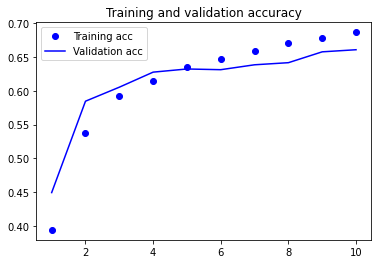

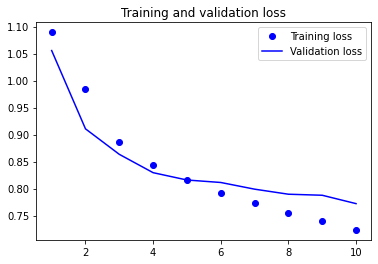

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model.evaluate(x_test, y_test)

101/101 [==============================] - 13s 130ms/step - loss: 0.7784 - acc: 0.6629


[0.7784168124198914, 0.6629457473754883]

In [ ]:
pred=lstm_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 13s 126ms/step
              precision    recall  f1-score   support

         neg       0.59      0.69      0.64       918
           n       0.54      0.69      0.60       822
         pos       0.86      0.64      0.73      1485

    accuracy                           0.66      3225
   macro avg       0.66      0.67      0.66      3225
weighted avg       0.70      0.66      0.67      3225



In [ ]:
# definirea modelului------------16--------------
lstm_model2 = Sequential()
lstm_model2.add(embedding_layer)
lstm_model2.add(LSTM(16))
lstm_model2.add(Dense(3, activation = 'softmax'))

lstm_model2.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model2.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 138s 783ms/step - loss: 1.0763 - acc: 0.4111 - val_loss: 1.0442 - val_acc: 0.4517
Epoch 2/10
172/172 [==============================] - 135s 785ms/step - loss: 0.9753 - acc: 0.5187 - val_loss: 0.8969 - val_acc: 0.5674
Epoch 3/10
172/172 [==============================] - 132s 767ms/step - loss: 0.8375 - acc: 0.6118 - val_loss: 0.8468 - val_acc: 0.5917
Epoch 4/10
172/172 [==============================] - 135s 786ms/step - loss: 0.7868 - acc: 0.6386 - val_loss: 0.8166 - val_acc: 0.6186
Epoch 5/10
172/172 [==============================] - 135s 783ms/step - loss: 0.7546 - acc: 0.6604 - val_loss: 0.8107 - val_acc: 0.6191
Epoch 6/10
172/172 [==============================] - 133s 776ms/step - loss: 0.7273 - acc: 0.6782 - val_loss: 0.7870 - val_acc: 0.6424
Epoch 7/10
172/172 [==============================] - 134s 777ms/step - loss: 0.7042 - acc: 0.6920 - val_loss: 0.7789 - val_acc: 0.6465
Epoch 8/10
172/172 [============================

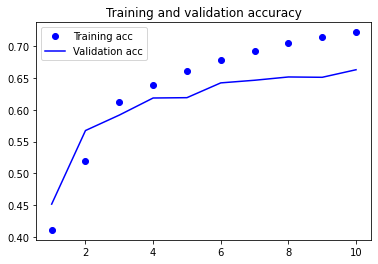

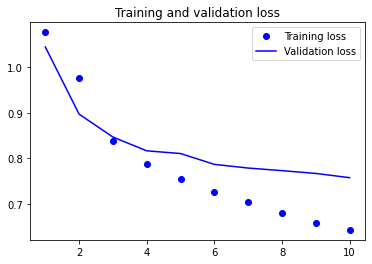

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model2.evaluate(x_test, y_test)

101/101 [==============================] - 20s 197ms/step - loss: 0.7547 - acc: 0.6651


[0.7546588778495789, 0.6651162505149841]

In [ ]:
pred=lstm_model2.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 19s 181ms/step
              precision    recall  f1-score   support

         neg       0.66      0.65      0.65      1096
           n       0.56      0.67      0.61       881
         pos       0.77      0.68      0.72      1248

    accuracy                           0.67      3225
   macro avg       0.66      0.66      0.66      3225
weighted avg       0.68      0.67      0.67      3225



In [ ]:
# definirea modelului------------32--------------
lstm_model3 = Sequential()
lstm_model3.add(embedding_layer)
lstm_model3.add(LSTM(32))
lstm_model3.add(Dense(3, activation = 'softmax'))

lstm_model3.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model3.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 167s 957ms/step - loss: 1.0045 - acc: 0.4872 - val_loss: 0.8641 - val_acc: 0.5928
Epoch 2/10
172/172 [==============================] - 161s 934ms/step - loss: 0.8230 - acc: 0.6171 - val_loss: 0.8178 - val_acc: 0.6114
Epoch 3/10
172/172 [==============================] - 161s 936ms/step - loss: 0.7687 - acc: 0.6495 - val_loss: 0.7912 - val_acc: 0.6264
Epoch 4/10
172/172 [==============================] - 161s 939ms/step - loss: 0.7330 - acc: 0.6741 - val_loss: 0.8034 - val_acc: 0.6439
Epoch 5/10
172/172 [==============================] - 162s 943ms/step - loss: 0.6998 - acc: 0.6879 - val_loss: 0.7893 - val_acc: 0.6320
Epoch 6/10
172/172 [==============================] - 162s 940ms/step - loss: 0.6634 - acc: 0.7099 - val_loss: 0.7669 - val_acc: 0.6496
Epoch 7/10
172/172 [==============================] - 163s 946ms/step - loss: 0.6385 - acc: 0.7220 - val_loss: 0.7565 - val_acc: 0.6682
Epoch 8/10
172/172 [============================

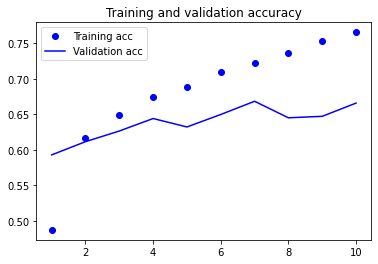

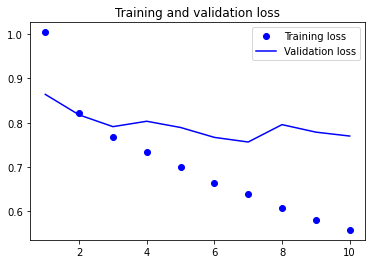

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model3.evaluate(x_test, y_test)

101/101 [==============================] - 24s 233ms/step - loss: 0.7530 - acc: 0.6639


[0.7530330419540405, 0.6638759970664978]

In [ ]:
pred=lstm_model3.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 25s 241ms/step
              precision    recall  f1-score   support

         neg       0.73      0.61      0.67      1285
           n       0.48      0.75      0.59       685
         pos       0.77      0.67      0.72      1255

    accuracy                           0.66      3225
   macro avg       0.66      0.68      0.66      3225
weighted avg       0.69      0.66      0.67      3225



In [ ]:
# definirea modelului------------64--------------
lstm_model4 = Sequential()
lstm_model4.add(embedding_layer)
lstm_model4.add(LSTM(64))
lstm_model4.add(Dense(3, activation = 'softmax'))

lstm_model4.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model4.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 333s 2s/step - loss: 0.9487 - acc: 0.5216 - val_loss: 0.8118 - val_acc: 0.6134
Epoch 2/10
172/172 [==============================] - 331s 2s/step - loss: 0.7775 - acc: 0.6472 - val_loss: 0.7611 - val_acc: 0.6651
Epoch 3/10
172/172 [==============================] - 328s 2s/step - loss: 0.7145 - acc: 0.6839 - val_loss: 0.7532 - val_acc: 0.6553
Epoch 4/10
172/172 [==============================] - 328s 2s/step - loss: 0.6588 - acc: 0.7124 - val_loss: 0.7292 - val_acc: 0.6879
Epoch 5/10
172/172 [==============================] - 340s 2s/step - loss: 0.6161 - acc: 0.7340 - val_loss: 0.7185 - val_acc: 0.6889
Epoch 6/10
172/172 [==============================] - 333s 2s/step - loss: 0.5756 - acc: 0.7544 - val_loss: 0.7790 - val_acc: 0.6460
Epoch 7/10
172/172 [==============================] - 333s 2s/step - loss: 0.5313 - acc: 0.7787 - val_loss: 0.7097 - val_acc: 0.6904
Epoch 8/10
172/172 [==============================] - 332s 2s/step - 

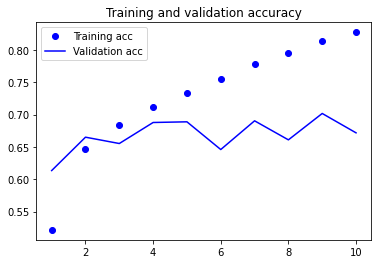

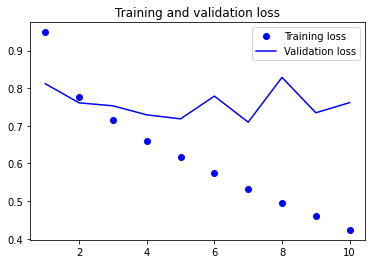

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model4.evaluate(x_test, y_test)

101/101 [==============================] - 29s 285ms/step - loss: 0.7561 - acc: 0.6716


[0.7561180591583252, 0.6716278791427612]

In [ ]:
pred=lstm_model4.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 29s 283ms/step
              precision    recall  f1-score   support

         neg       0.67      0.71      0.69      1013
           n       0.61      0.61      0.61      1066
         pos       0.73      0.70      0.71      1146

    accuracy                           0.67      3225
   macro avg       0.67      0.67      0.67      3225
weighted avg       0.67      0.67      0.67      3225



In [ ]:
# definirea modelului------------128--------------
lstm_model5 = Sequential()
lstm_model5.add(embedding_layer)
lstm_model5.add(LSTM(128))
lstm_model5.add(Dense(3, activation = 'softmax'))

lstm_model5.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model5.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 754s 4s/step - loss: 0.8946 - acc: 0.5531 - val_loss: 1.0020 - val_acc: 0.4935
Epoch 2/10
172/172 [==============================] - 745s 4s/step - loss: 0.7534 - acc: 0.6575 - val_loss: 0.7482 - val_acc: 0.6532
Epoch 3/10
172/172 [==============================] - 739s 4s/step - loss: 0.6817 - acc: 0.6944 - val_loss: 0.7617 - val_acc: 0.6610
Epoch 4/10
172/172 [==============================] - 739s 4s/step - loss: 0.6246 - acc: 0.7286 - val_loss: 0.8402 - val_acc: 0.6553
Epoch 5/10
172/172 [==============================] - 733s 4s/step - loss: 0.5668 - acc: 0.7600 - val_loss: 0.7119 - val_acc: 0.6822
Epoch 6/10
172/172 [==============================] - 737s 4s/step - loss: 0.5035 - acc: 0.7916 - val_loss: 0.7591 - val_acc: 0.6879
Epoch 7/10
172/172 [==============================] - 736s 4s/step - loss: 0.4442 - acc: 0.8207 - val_loss: 0.7595 - val_acc: 0.6708
Epoch 8/10
172/172 [==============================] - 733s 4s/step - 

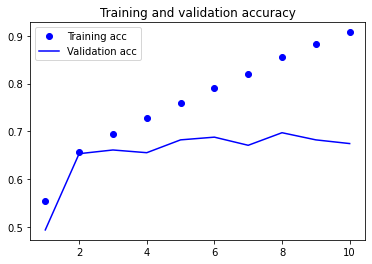

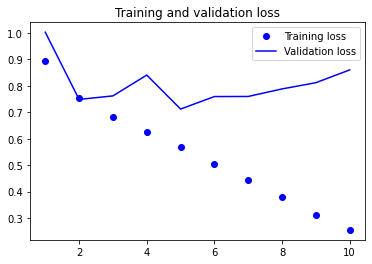

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model5.evaluate(x_test, y_test)

101/101 [==============================] - 102s 1s/step - loss: 0.8422 - acc: 0.6819


[0.8422372341156006, 0.6818604469299316]

In [ ]:
pred=lstm_model5.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 99s 976ms/step
              precision    recall  f1-score   support

         neg       0.69      0.67      0.68      1107
           n       0.62      0.64      0.63      1021
         pos       0.73      0.74      0.73      1097

    accuracy                           0.68      3225
   macro avg       0.68      0.68      0.68      3225
weighted avg       0.68      0.68      0.68      3225



In [ ]:
# definirea modelului------------256--------------
lstm_model6 = Sequential()
lstm_model6.add(embedding_layer)
lstm_model6.add(LSTM(256))
lstm_model6.add(Dense(3, activation = 'softmax'))

lstm_model6.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model6.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 1807s 10s/step - loss: 0.9112 - acc: 0.5496 - val_loss: 0.8081 - val_acc: 0.6010
Epoch 2/10
172/172 [==============================] - 1813s 11s/step - loss: 0.7809 - acc: 0.6389 - val_loss: 0.7854 - val_acc: 0.6279
Epoch 3/10
172/172 [==============================] - 1808s 11s/step - loss: 0.6810 - acc: 0.6969 - val_loss: 0.7225 - val_acc: 0.6698
Epoch 4/10
172/172 [==============================] - 1790s 10s/step - loss: 0.6028 - acc: 0.7381 - val_loss: 0.7059 - val_acc: 0.6889
Epoch 5/10
172/172 [==============================] - 1785s 10s/step - loss: 0.5146 - acc: 0.7863 - val_loss: 0.7818 - val_acc: 0.6770
Epoch 6/10
172/172 [==============================] - 1790s 10s/step - loss: 0.4113 - acc: 0.8375 - val_loss: 0.8811 - val_acc: 0.6171
Epoch 7/10
172/172 [==============================] - 1769s 10s/step - loss: 0.3082 - acc: 0.8853 - val_loss: 0.8911 - val_acc: 0.6424
Epoch 8/10
172/172 [==============================] - 1

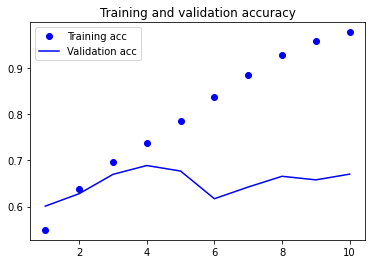

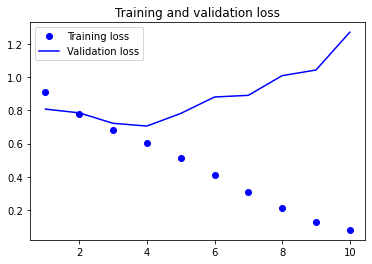

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model6.evaluate(x_test, y_test)

101/101 [==============================] - 212s 2s/step - loss: 1.2559 - acc: 0.6704


[1.2558947801589966, 0.6703876256942749]

In [ ]:
pred=lstm_model6.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

101/101 [==============================] - 229s 2s/step
              precision    recall  f1-score   support

         neg       0.54      0.76      0.63       751
           n       0.62      0.63      0.62      1044
         pos       0.85      0.66      0.74      1430

    accuracy                           0.67      3225
   macro avg       0.67      0.68      0.66      3225
weighted avg       0.70      0.67      0.68      3225



In [ ]:
============================================     H E R E NEXT 512        ===================================================

In [ ]:
# definirea modelului------------512--------------
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(512))
lstm_model.add(Dense(3, activation = 'softmax'))

lstm_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 445s 3s/step - loss: 0.8997 - acc: 0.6062 - val_loss: 0.7776 - val_acc: 0.6770
Epoch 2/10
172/172 [==============================] - 442s 3s/step - loss: 0.6642 - acc: 0.7174 - val_loss: 0.7496 - val_acc: 0.6765
Epoch 3/10
172/172 [==============================] - 442s 3s/step - loss: 0.5983 - acc: 0.7465 - val_loss: 0.6150 - val_acc: 0.7349
Epoch 4/10
172/172 [==============================] - 443s 3s/step - loss: 0.5995 - acc: 0.7499 - val_loss: 0.6375 - val_acc: 0.7147
Epoch 5/10
172/172 [==============================] - 442s 3s/step - loss: 0.5760 - acc: 0.7515 - val_loss: 0.6602 - val_acc: 0.7230
Epoch 6/10
172/172 [==============================] - 443s 3s/step - loss: 0.5532 - acc: 0.7692 - val_loss: 0.6178 - val_acc: 0.7302
Epoch 7/10
172/172 [==============================] - 443s 3s/step - loss: 0.4825 - acc: 0.7988 - val_loss: 0.6694 - val_acc: 0.7437
Epoch 8/10
172/172 [==============================] - 442s 3s/step - 

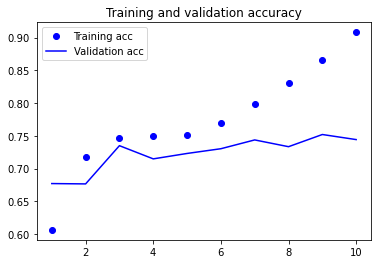

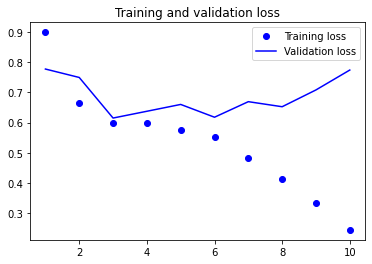

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului------------512----256----------
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(512, return_sequences = True))
lstm_model.add(LSTM(256))
lstm_model.add(Dense(3, activation = 'softmax'))

lstm_model.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])
history = lstm_model.fit(x_train, 
                         y_train,
                         epochs=10,
                         batch_size=64,
                         validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 739s 4s/step - loss: 0.8690 - acc: 0.6198 - val_loss: 0.7095 - val_acc: 0.6977
Epoch 2/10
172/172 [==============================] - 725s 4s/step - loss: 0.6779 - acc: 0.7088 - val_loss: 0.6456 - val_acc: 0.7220
Epoch 3/10
172/172 [==============================] - 716s 4s/step - loss: 0.6113 - acc: 0.7422 - val_loss: 0.6452 - val_acc: 0.7214
Epoch 4/10
172/172 [==============================] - 709s 4s/step - loss: 0.6325 - acc: 0.7249 - val_loss: 0.6154 - val_acc: 0.7375
Epoch 5/10
172/172 [==============================] - 700s 4s/step - loss: 0.5720 - acc: 0.7504 - val_loss: 0.5961 - val_acc: 0.7488
Epoch 6/10
172/172 [==============================] - 699s 4s/step - loss: 0.5363 - acc: 0.7725 - val_loss: 0.5840 - val_acc: 0.7514
Epoch 7/10
172/172 [==============================] - 695s 4s/step - loss: 0.4861 - acc: 0.7964 - val_loss: 0.6065 - val_acc: 0.7478
Epoch 8/10
172/172 [==============================] - 693s 4s/step - 

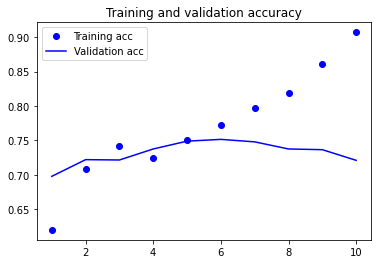

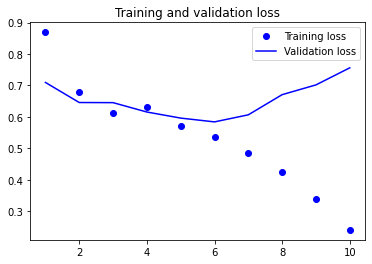

In [ ]:
plot_graphs(history)

In [ ]:
lstm_model.evaluate(x_test, y_test)

101/101 [==============================] - 93s 916ms/step - loss: 0.8152 - acc: 0.7126


[0.8151720762252808, 0.7125581502914429]

In [ ]:
pred=lstm_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.77      0.71      0.74      1179
           n       0.61      0.65      0.63      1009
         pos       0.75      0.77      0.76      1037

    accuracy                           0.71      3225
   macro avg       0.71      0.71      0.71      3225
weighted avg       0.72      0.71      0.71      3225



In [ ]:
lstm_model.save('Models/w2v_lstm_model.h5')

### GRU

In [ ]:
# definirea modelului ------------------8------------------
gru_model1 = Sequential()
gru_model1.add(embedding_layer)
gru_model1.add(GRU(8))
gru_model1.add(Dense(3, activation = 'softmax'))

gru_model1.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model1.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 75s 422ms/step - loss: 1.0130 - acc: 0.5045 - val_loss: 0.9538 - val_acc: 0.5504
Epoch 2/10
172/172 [==============================] - 72s 419ms/step - loss: 0.8637 - acc: 0.6242 - val_loss: 0.7914 - val_acc: 0.6625
Epoch 3/10
172/172 [==============================] - 73s 426ms/step - loss: 0.7328 - acc: 0.6956 - val_loss: 0.7090 - val_acc: 0.7028
Epoch 4/10
172/172 [==============================] - 73s 422ms/step - loss: 0.6842 - acc: 0.7205 - val_loss: 0.6940 - val_acc: 0.7178
Epoch 5/10
172/172 [==============================] - 75s 437ms/step - loss: 0.6604 - acc: 0.7249 - val_loss: 0.6780 - val_acc: 0.7101
Epoch 6/10
172/172 [==============================] - 72s 420ms/step - loss: 0.6484 - acc: 0.7302 - val_loss: 0.6877 - val_acc: 0.7008
Epoch 7/10
172/172 [==============================] - 71s 415ms/step - loss: 0.6367 - acc: 0.7354 - val_loss: 0.6677 - val_acc: 0.7142
Epoch 8/10
172/172 [==============================] - 7

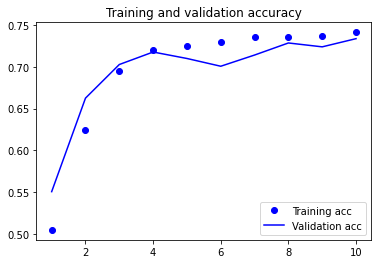

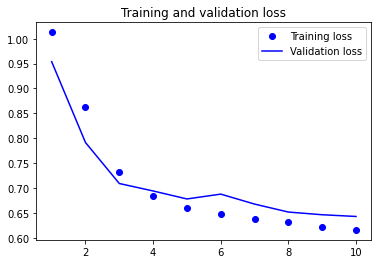

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului ------------------16------------------
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(GRU(16))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 85s 480ms/step - loss: 0.9477 - acc: 0.5511 - val_loss: 0.8078 - val_acc: 0.6563
Epoch 2/10
172/172 [==============================] - 82s 480ms/step - loss: 0.7127 - acc: 0.6996 - val_loss: 0.6787 - val_acc: 0.7137
Epoch 3/10
172/172 [==============================] - 87s 505ms/step - loss: 0.6473 - acc: 0.7253 - val_loss: 0.6626 - val_acc: 0.7209
Epoch 4/10
172/172 [==============================] - 86s 498ms/step - loss: 0.6208 - acc: 0.7335 - val_loss: 0.6253 - val_acc: 0.7411
Epoch 5/10
172/172 [==============================] - 86s 502ms/step - loss: 0.6065 - acc: 0.7427 - val_loss: 0.6459 - val_acc: 0.7189
Epoch 6/10
172/172 [==============================] - 86s 503ms/step - loss: 0.5946 - acc: 0.7459 - val_loss: 0.6298 - val_acc: 0.7245
Epoch 7/10
172/172 [==============================] - 84s 490ms/step - loss: 0.5844 - acc: 0.7519 - val_loss: 0.6147 - val_acc: 0.7328
Epoch 8/10
172/172 [==============================] - 8

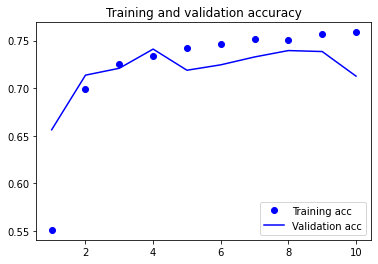

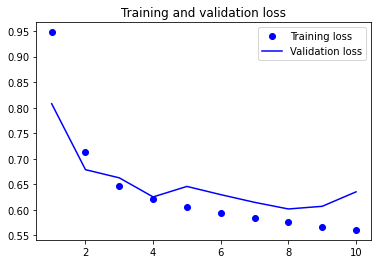

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului ------------------32------------------
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(GRU(32))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 103s 585ms/step - loss: 0.8824 - acc: 0.5908 - val_loss: 0.7070 - val_acc: 0.6992
Epoch 2/10
172/172 [==============================] - 102s 593ms/step - loss: 0.6737 - acc: 0.7124 - val_loss: 0.6445 - val_acc: 0.7194
Epoch 3/10
172/172 [==============================] - 96s 556ms/step - loss: 0.6299 - acc: 0.7308 - val_loss: 0.6283 - val_acc: 0.7302
Epoch 4/10
172/172 [==============================] - 95s 550ms/step - loss: 0.6025 - acc: 0.7466 - val_loss: 0.6359 - val_acc: 0.7173
Epoch 5/10
172/172 [==============================] - 104s 607ms/step - loss: 0.5857 - acc: 0.7504 - val_loss: 0.6030 - val_acc: 0.7463
Epoch 6/10
172/172 [==============================] - 99s 572ms/step - loss: 0.5718 - acc: 0.7560 - val_loss: 0.6491 - val_acc: 0.7230
Epoch 7/10
172/172 [==============================] - 101s 591ms/step - loss: 0.5517 - acc: 0.7647 - val_loss: 0.5905 - val_acc: 0.7416
Epoch 8/10
172/172 [==============================]

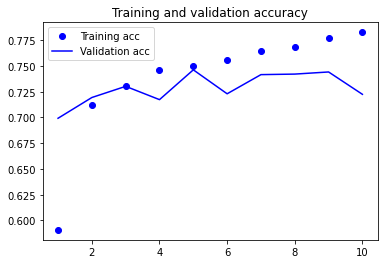

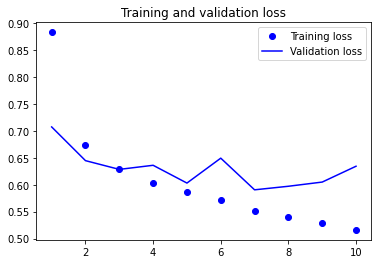

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului ------------------64------------------
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(GRU(64))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 124s 702ms/step - loss: 0.8523 - acc: 0.6074 - val_loss: 0.8443 - val_acc: 0.6320
Epoch 2/10
172/172 [==============================] - 119s 695ms/step - loss: 0.6704 - acc: 0.7169 - val_loss: 0.7259 - val_acc: 0.6899
Epoch 3/10
172/172 [==============================] - 120s 697ms/step - loss: 0.6207 - acc: 0.7350 - val_loss: 0.6192 - val_acc: 0.7344
Epoch 4/10
172/172 [==============================] - 120s 698ms/step - loss: 0.5897 - acc: 0.7497 - val_loss: 0.6132 - val_acc: 0.7359
Epoch 5/10
172/172 [==============================] - 122s 712ms/step - loss: 0.5660 - acc: 0.7604 - val_loss: 0.6933 - val_acc: 0.7199
Epoch 6/10
172/172 [==============================] - 119s 693ms/step - loss: 0.5405 - acc: 0.7694 - val_loss: 0.5954 - val_acc: 0.7359
Epoch 7/10
172/172 [==============================] - 117s 680ms/step - loss: 0.5224 - acc: 0.7808 - val_loss: 0.6399 - val_acc: 0.7152
Epoch 8/10
172/172 [============================

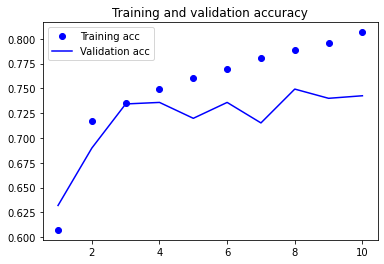

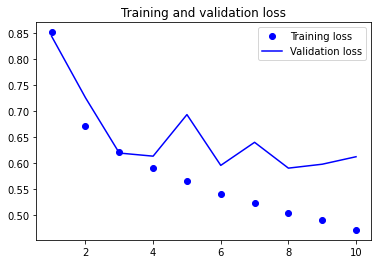

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului ------------------128------------------
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(GRU(128))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 690s 4s/step - loss: 0.8310 - acc: 0.6208 - val_loss: 0.7323 - val_acc: 0.6827
Epoch 2/10
172/172 [==============================] - 731s 4s/step - loss: 0.6525 - acc: 0.7197 - val_loss: 0.7223 - val_acc: 0.6956
Epoch 3/10
172/172 [==============================] - 719s 4s/step - loss: 0.5971 - acc: 0.7448 - val_loss: 0.6568 - val_acc: 0.6910
Epoch 4/10
172/172 [==============================] - 745s 4s/step - loss: 0.5636 - acc: 0.7563 - val_loss: 0.6819 - val_acc: 0.6827
Epoch 5/10
172/172 [==============================] - 732s 4s/step - loss: 0.5301 - acc: 0.7734 - val_loss: 0.6060 - val_acc: 0.7266
Epoch 6/10
172/172 [==============================] - 757s 4s/step - loss: 0.5034 - acc: 0.7873 - val_loss: 0.5838 - val_acc: 0.7468
Epoch 7/10
172/172 [==============================] - 734s 4s/step - loss: 0.4726 - acc: 0.8032 - val_loss: 0.6212 - val_acc: 0.7432
Epoch 8/10
172/172 [==============================] - 756s 4s/step - 

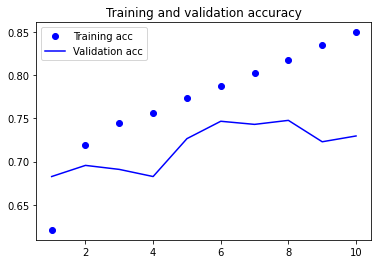

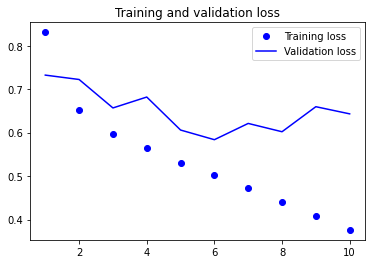

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului ------------------256------------------
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(GRU(256))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 192s 1s/step - loss: 0.8433 - acc: 0.6150 - val_loss: 0.7257 - val_acc: 0.6930
Epoch 2/10
172/172 [==============================] - 188s 1s/step - loss: 0.6484 - acc: 0.7207 - val_loss: 0.6127 - val_acc: 0.7261
Epoch 3/10
172/172 [==============================] - 187s 1s/step - loss: 0.5853 - acc: 0.7513 - val_loss: 0.6206 - val_acc: 0.7199
Epoch 4/10
172/172 [==============================] - 187s 1s/step - loss: 0.5424 - acc: 0.7714 - val_loss: 0.5870 - val_acc: 0.7478
Epoch 5/10
172/172 [==============================] - 187s 1s/step - loss: 0.4967 - acc: 0.7902 - val_loss: 0.5830 - val_acc: 0.7561
Epoch 6/10
172/172 [==============================] - 185s 1s/step - loss: 0.4549 - acc: 0.8132 - val_loss: 0.6110 - val_acc: 0.7504
Epoch 7/10
172/172 [==============================] - 184s 1s/step - loss: 0.4026 - acc: 0.8356 - val_loss: 0.6333 - val_acc: 0.7401
Epoch 8/10
172/172 [==============================] - 183s 1s/step - 

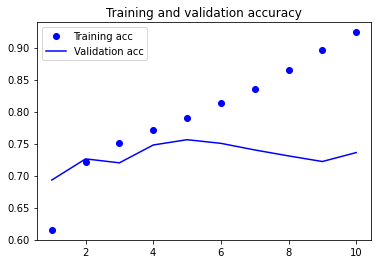

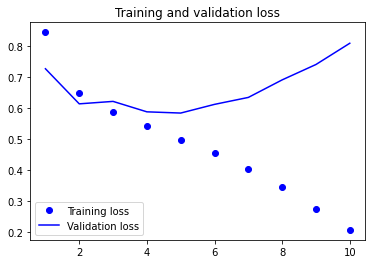

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului ------------------512------------------
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(GRU(512))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 391s 2s/step - loss: 0.8652 - acc: 0.6054 - val_loss: 0.6738 - val_acc: 0.7085
Epoch 2/10
172/172 [==============================] - 389s 2s/step - loss: 0.6448 - acc: 0.7243 - val_loss: 0.6370 - val_acc: 0.7059
Epoch 3/10
172/172 [==============================] - 386s 2s/step - loss: 0.5795 - acc: 0.7488 - val_loss: 0.6814 - val_acc: 0.7101
Epoch 4/10
172/172 [==============================] - 384s 2s/step - loss: 0.5251 - acc: 0.7784 - val_loss: 0.7190 - val_acc: 0.6977
Epoch 5/10
172/172 [==============================] - 384s 2s/step - loss: 0.4608 - acc: 0.8057 - val_loss: 0.6069 - val_acc: 0.7375
Epoch 6/10
172/172 [==============================] - 382s 2s/step - loss: 0.3776 - acc: 0.8474 - val_loss: 0.6634 - val_acc: 0.7287
Epoch 7/10
172/172 [==============================] - 380s 2s/step - loss: 0.2789 - acc: 0.8901 - val_loss: 0.7569 - val_acc: 0.7085
Epoch 8/10
172/172 [==============================] - 380s 2s/step - 

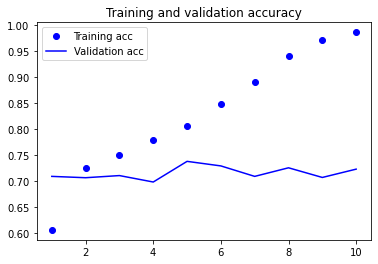

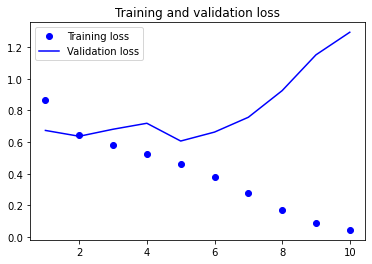

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului ------------------512----256--------------
gru_model = Sequential()
gru_model.add(embedding_layer)
gru_model.add(GRU(512, return_sequences = True))
gru_model.add(GRU(256))
gru_model.add(Dense(3, activation = 'softmax'))

gru_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])
history = gru_model.fit(x_train,
                        y_train,
                        epochs=10,
                        batch_size=64,
                        validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 583s 3s/step - loss: 0.8790 - acc: 0.5943 - val_loss: 0.7346 - val_acc: 0.6879
Epoch 2/10
172/172 [==============================] - 578s 3s/step - loss: 0.6532 - acc: 0.7192 - val_loss: 0.6722 - val_acc: 0.7054
Epoch 3/10
172/172 [==============================] - 578s 3s/step - loss: 0.5791 - acc: 0.7551 - val_loss: 0.6242 - val_acc: 0.7214
Epoch 4/10
172/172 [==============================] - 578s 3s/step - loss: 0.5195 - acc: 0.7826 - val_loss: 0.6869 - val_acc: 0.7214
Epoch 5/10
172/172 [==============================] - 577s 3s/step - loss: 0.4478 - acc: 0.8140 - val_loss: 0.6493 - val_acc: 0.7380
Epoch 6/10
172/172 [==============================] - 577s 3s/step - loss: 0.3463 - acc: 0.8619 - val_loss: 0.7299 - val_acc: 0.7209
Epoch 7/10
172/172 [==============================] - 578s 3s/step - loss: 0.2927 - acc: 0.8895 - val_loss: 0.7967 - val_acc: 0.7235
Epoch 8/10
172/172 [==============================] - 578s 3s/step - 

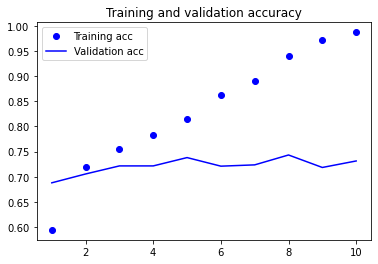

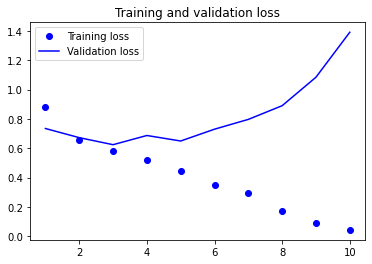

In [ ]:
plot_graphs(history)

In [ ]:
gru_model.evaluate(x_test, y_test)

101/101 [==============================] - 75s 742ms/step - loss: 1.4537 - acc: 0.7312


[1.4537092447280884, 0.7311627864837646]

In [ ]:
pred=gru_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.73      0.75      0.74      1065
           n       0.59      0.73      0.65       876
         pos       0.88      0.72      0.79      1284

    accuracy                           0.73      3225
   macro avg       0.73      0.73      0.73      3225
weighted avg       0.75      0.73      0.74      3225



In [ ]:
gru_model.save('Models/w2v_gru_model.h5')

### Convnet 1D

In [ ]:
# definirea modelului---------8------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(8, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(8, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 15s 81ms/step - loss: 1.0827 - acc: 0.4230 - val_loss: 1.0477 - val_acc: 0.4382
Epoch 2/10
172/172 [==============================] - 14s 81ms/step - loss: 1.0333 - acc: 0.4764 - val_loss: 1.0218 - val_acc: 0.4827
Epoch 3/10
172/172 [==============================] - 14s 81ms/step - loss: 1.0049 - acc: 0.5135 - val_loss: 0.9980 - val_acc: 0.5075
Epoch 4/10
172/172 [==============================] - 14s 80ms/step - loss: 0.9794 - acc: 0.5330 - val_loss: 0.9778 - val_acc: 0.5282
Epoch 5/10
172/172 [==============================] - 14s 81ms/step - loss: 0.9550 - acc: 0.5496 - val_loss: 0.9583 - val_acc: 0.5426
Epoch 6/10
172/172 [==============================] - 14s 82ms/step - loss: 0.9320 - acc: 0.5606 - val_loss: 0.9410 - val_acc: 0.5535
Epoch 7/10
172/172 [==============================] - 14s 81ms/step - loss: 0.9104 - acc: 0.5716 - val_loss: 0.9248 - val_acc: 0.5592
Epoch 8/10
172/172 [==============================] - 14s 81ms

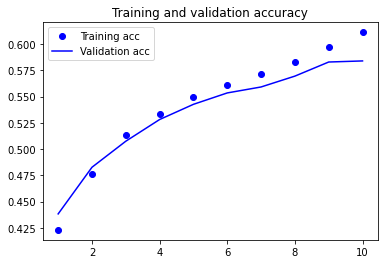

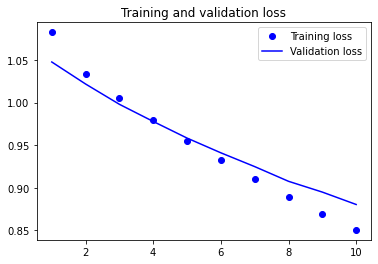

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului---------16------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(16, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(16, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 15s 86ms/step - loss: 1.0080 - acc: 0.5099 - val_loss: 0.9742 - val_acc: 0.5437
Epoch 2/10
172/172 [==============================] - 15s 87ms/step - loss: 0.9203 - acc: 0.5899 - val_loss: 0.9134 - val_acc: 0.5809
Epoch 3/10
172/172 [==============================] - 15s 85ms/step - loss: 0.8628 - acc: 0.6150 - val_loss: 0.8750 - val_acc: 0.5969
Epoch 4/10
172/172 [==============================] - 15s 86ms/step - loss: 0.8224 - acc: 0.6271 - val_loss: 0.8483 - val_acc: 0.6021
Epoch 5/10
172/172 [==============================] - 15s 86ms/step - loss: 0.7922 - acc: 0.6377 - val_loss: 0.8386 - val_acc: 0.5990
Epoch 6/10
172/172 [==============================] - 15s 86ms/step - loss: 0.7690 - acc: 0.6486 - val_loss: 0.8174 - val_acc: 0.6072
Epoch 7/10
172/172 [==============================] - 15s 86ms/step - loss: 0.7493 - acc: 0.6524 - val_loss: 0.8090 - val_acc: 0.6134
Epoch 8/10
172/172 [==============================] - 15s 85ms

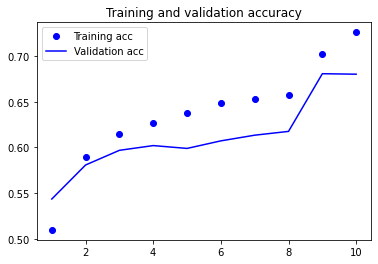

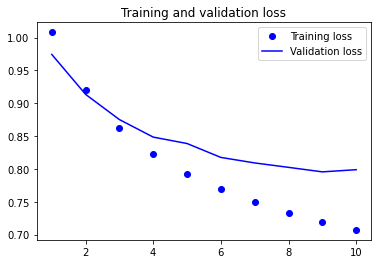

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului---------32------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(32, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(32, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 18s 99ms/step - loss: 0.9809 - acc: 0.5602 - val_loss: 0.9083 - val_acc: 0.6496
Epoch 2/10
172/172 [==============================] - 17s 99ms/step - loss: 0.8593 - acc: 0.6536 - val_loss: 0.8499 - val_acc: 0.6708
Epoch 3/10
172/172 [==============================] - 17s 98ms/step - loss: 0.7975 - acc: 0.6769 - val_loss: 0.8141 - val_acc: 0.6796
Epoch 4/10
172/172 [==============================] - 17s 98ms/step - loss: 0.7543 - acc: 0.6992 - val_loss: 0.7918 - val_acc: 0.6930
Epoch 5/10
172/172 [==============================] - 17s 99ms/step - loss: 0.7217 - acc: 0.7131 - val_loss: 0.7753 - val_acc: 0.6925
Epoch 6/10
172/172 [==============================] - 17s 98ms/step - loss: 0.6945 - acc: 0.7245 - val_loss: 0.7725 - val_acc: 0.6749
Epoch 7/10
172/172 [==============================] - 17s 98ms/step - loss: 0.6729 - acc: 0.7341 - val_loss: 0.7564 - val_acc: 0.6925
Epoch 8/10
172/172 [==============================] - 17s 98ms

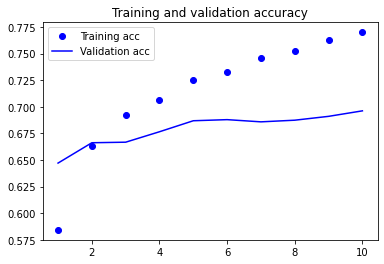

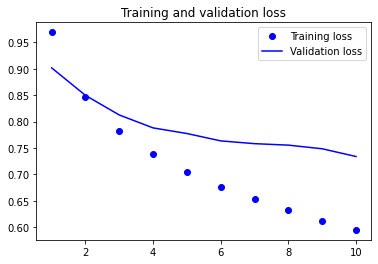

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului---------64------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(64, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(64, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 56s 321ms/step - loss: 0.9161 - acc: 0.6350 - val_loss: 0.8550 - val_acc: 0.6656
Epoch 2/10
172/172 [==============================] - 55s 320ms/step - loss: 0.7870 - acc: 0.6964 - val_loss: 0.7919 - val_acc: 0.6946
Epoch 3/10
172/172 [==============================] - 55s 318ms/step - loss: 0.7254 - acc: 0.7181 - val_loss: 0.8043 - val_acc: 0.6972
Epoch 4/10
172/172 [==============================] - 57s 331ms/step - loss: 0.6824 - acc: 0.7385 - val_loss: 0.7506 - val_acc: 0.7070
Epoch 5/10
172/172 [==============================] - 56s 325ms/step - loss: 0.6470 - acc: 0.7526 - val_loss: 0.7733 - val_acc: 0.6801
Epoch 6/10
172/172 [==============================] - 56s 327ms/step - loss: 0.6155 - acc: 0.7647 - val_loss: 0.7355 - val_acc: 0.6987
Epoch 7/10
172/172 [==============================] - 56s 325ms/step - loss: 0.5902 - acc: 0.7757 - val_loss: 0.7350 - val_acc: 0.7003
Epoch 8/10
172/172 [==============================] - 5

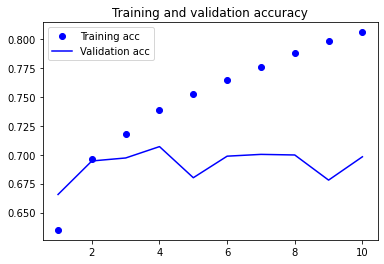

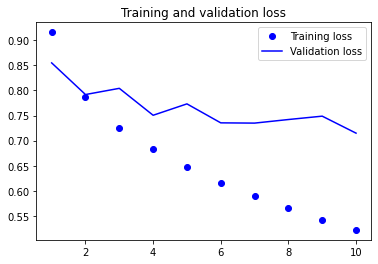

In [ ]:
plot_graphs(history)

In [ ]:
convnet_model.evaluate(x_test,y_test)

101/101 [==============================] - 5s 44ms/step - loss: 0.7143 - acc: 0.6974


[0.7143205404281616, 0.697364330291748]

In [ ]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.67      0.72      0.69      1002
           n       0.63      0.66      0.64      1032
         pos       0.80      0.71      0.75      1191

    accuracy                           0.70      3225
   macro avg       0.70      0.70      0.70      3225
weighted avg       0.70      0.70      0.70      3225



In [ ]:
# definirea modelului---------128------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(128, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(128, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 80s 462ms/step - loss: 0.9056 - acc: 0.6296 - val_loss: 0.8418 - val_acc: 0.6713
Epoch 2/10
172/172 [==============================] - 80s 462ms/step - loss: 0.7654 - acc: 0.6962 - val_loss: 0.7913 - val_acc: 0.6848
Epoch 3/10
172/172 [==============================] - 84s 487ms/step - loss: 0.6949 - acc: 0.7278 - val_loss: 0.7593 - val_acc: 0.6889
Epoch 4/10
172/172 [==============================] - 86s 501ms/step - loss: 0.6386 - acc: 0.7512 - val_loss: 0.7528 - val_acc: 0.6992
Epoch 5/10
172/172 [==============================] - 84s 489ms/step - loss: 0.5957 - acc: 0.7668 - val_loss: 0.7333 - val_acc: 0.6956
Epoch 6/10
172/172 [==============================] - 82s 478ms/step - loss: 0.5590 - acc: 0.7871 - val_loss: 0.7372 - val_acc: 0.6837
Epoch 7/10
172/172 [==============================] - 82s 479ms/step - loss: 0.5252 - acc: 0.8019 - val_loss: 0.7168 - val_acc: 0.6966
Epoch 8/10
172/172 [==============================] - 8

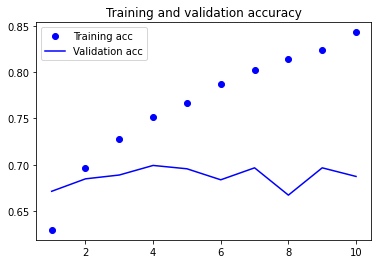

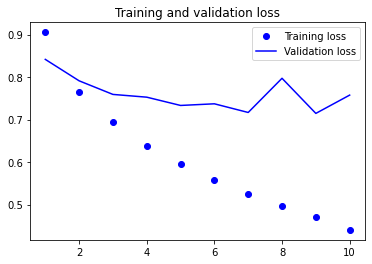

In [ ]:
plot_graphs(history)

In [ ]:
convnet_model.evaluate(x_test,y_test)

101/101 [==============================] - 7s 71ms/step - loss: 0.7547 - acc: 0.6825


[0.7547036409378052, 0.6824806332588196]

In [ ]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.51      0.82      0.63       678
           n       0.67      0.62      0.64      1171
         pos       0.87      0.67      0.76      1376

    accuracy                           0.68      3225
   macro avg       0.68      0.70      0.68      3225
weighted avg       0.72      0.68      0.69      3225



In [ ]:
# definirea modelului---------256------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(256, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(256, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 148s 856ms/step - loss: 0.8927 - acc: 0.6284 - val_loss: 0.9065 - val_acc: 0.6630
Epoch 2/10
172/172 [==============================] - 149s 865ms/step - loss: 0.7418 - acc: 0.7066 - val_loss: 0.8766 - val_acc: 0.5943
Epoch 3/10
172/172 [==============================] - 150s 870ms/step - loss: 0.6634 - acc: 0.7365 - val_loss: 0.7441 - val_acc: 0.6972
Epoch 4/10
172/172 [==============================] - 151s 880ms/step - loss: 0.6033 - acc: 0.7611 - val_loss: 0.7321 - val_acc: 0.7008
Epoch 5/10
172/172 [==============================] - 156s 908ms/step - loss: 0.5492 - acc: 0.7860 - val_loss: 0.7031 - val_acc: 0.7080
Epoch 6/10
172/172 [==============================] - 154s 893ms/step - loss: 0.5075 - acc: 0.8035 - val_loss: 0.7182 - val_acc: 0.7101
Epoch 7/10
172/172 [==============================] - 156s 907ms/step - loss: 0.4672 - acc: 0.8264 - val_loss: 0.7800 - val_acc: 0.6455
Epoch 8/10
172/172 [============================

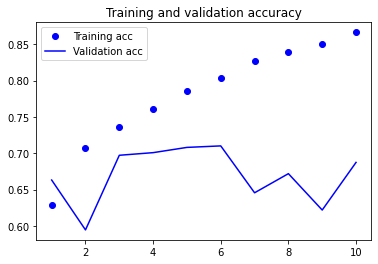

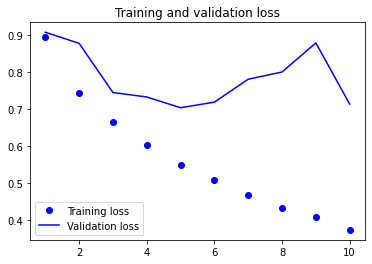

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului---------512------------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(512, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(512, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 95s 547ms/step - loss: 0.9076 - acc: 0.6264 - val_loss: 0.8728 - val_acc: 0.6620
Epoch 2/10
172/172 [==============================] - 94s 547ms/step - loss: 0.7341 - acc: 0.7084 - val_loss: 0.7921 - val_acc: 0.6739
Epoch 3/10
172/172 [==============================] - 94s 547ms/step - loss: 0.6414 - acc: 0.7472 - val_loss: 0.7214 - val_acc: 0.6946
Epoch 4/10
172/172 [==============================] - 94s 546ms/step - loss: 0.5659 - acc: 0.7753 - val_loss: 0.7723 - val_acc: 0.6693
Epoch 5/10
172/172 [==============================] - 94s 546ms/step - loss: 0.5075 - acc: 0.8010 - val_loss: 0.7126 - val_acc: 0.7070
Epoch 6/10
172/172 [==============================] - 94s 547ms/step - loss: 0.4491 - acc: 0.8310 - val_loss: 0.7296 - val_acc: 0.6966
Epoch 7/10
172/172 [==============================] - 94s 547ms/step - loss: 0.4079 - acc: 0.8469 - val_loss: 0.7490 - val_acc: 0.6946
Epoch 8/10
172/172 [==============================] - 9

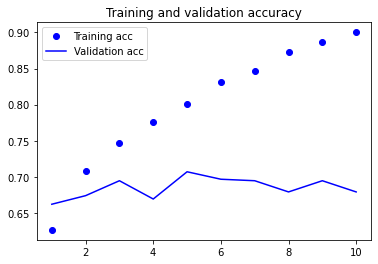

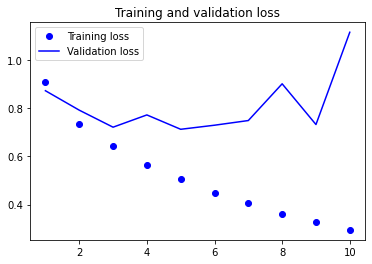

In [ ]:
plot_graphs(history)

In [ ]:
### increarca o combinatie diferita 

In [ ]:
# definirea modelului---------512---256---------------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(512, 7, activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(256, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/10
172/172 [==============================] - 83s 479ms/step - loss: 0.9101 - acc: 0.6281 - val_loss: 0.7831 - val_acc: 0.6837
Epoch 2/10
172/172 [==============================] - 82s 478ms/step - loss: 0.7296 - acc: 0.7118 - val_loss: 0.8485 - val_acc: 0.6481
Epoch 3/10
172/172 [==============================] - 82s 478ms/step - loss: 0.6348 - acc: 0.7508 - val_loss: 0.8032 - val_acc: 0.6408
Epoch 4/10
172/172 [==============================] - 82s 477ms/step - loss: 0.5630 - acc: 0.7798 - val_loss: 0.9366 - val_acc: 0.6842
Epoch 5/10
172/172 [==============================] - 82s 477ms/step - loss: 0.5073 - acc: 0.8054 - val_loss: 0.7165 - val_acc: 0.6904
Epoch 6/10
172/172 [==============================] - 82s 478ms/step - loss: 0.4566 - acc: 0.8250 - val_loss: 0.7700 - val_acc: 0.6615
Epoch 7/10
172/172 [==============================] - 82s 478ms/step - loss: 0.4088 - acc: 0.8482 - val_loss: 0.6853 - val_acc: 0.7080
Epoch 8/10
172/172 [==============================] - 8

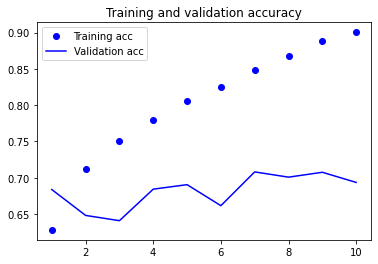

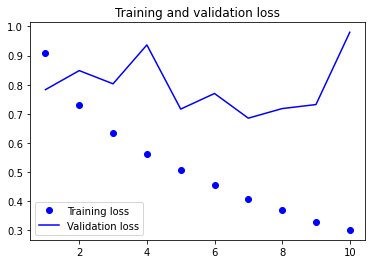

In [ ]:
plot_graphs(history)

In [ ]:
# definirea modelului---------512---256----128----l2(0.01)-------
convnet_model = Sequential()
convnet_model.add(embedding_layer)
convnet_model.add(Conv1D(512, 7, kernel_regularizer=l2(0.001), activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(256, 7, kernel_regularizer=l2(0.001), activation='relu'))
convnet_model.add(MaxPooling1D(5))
convnet_model.add(Conv1D(128, 7, activation='relu'))
convnet_model.add(GlobalMaxPooling1D())
convnet_model.add(Dense(3, activation='softmax'))

convnet_model.compile(optimizer=RMSprop(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])
history = convnet_model.fit(x_train, 
                            y_train,
                            epochs=20,
                            batch_size=64,
                            validation_split=0.15)

Epoch 1/20
172/172 [==============================] - 84s 486ms/step - loss: 1.5587 - acc: 0.6335 - val_loss: 1.4624 - val_acc: 0.6517
Epoch 2/20
172/172 [==============================] - 83s 482ms/step - loss: 1.3236 - acc: 0.6931 - val_loss: 1.3058 - val_acc: 0.6842
Epoch 3/20
172/172 [==============================] - 83s 482ms/step - loss: 1.2021 - acc: 0.7198 - val_loss: 1.2598 - val_acc: 0.6935
Epoch 4/20
172/172 [==============================] - 83s 482ms/step - loss: 1.1198 - acc: 0.7461 - val_loss: 1.2624 - val_acc: 0.6594
Epoch 5/20
172/172 [==============================] - 83s 482ms/step - loss: 1.0474 - acc: 0.7652 - val_loss: 1.2081 - val_acc: 0.6997
Epoch 6/20
172/172 [==============================] - 83s 482ms/step - loss: 0.9886 - acc: 0.7826 - val_loss: 1.1724 - val_acc: 0.6718
Epoch 7/20
172/172 [==============================] - 83s 481ms/step - loss: 0.9361 - acc: 0.7972 - val_loss: 1.2306 - val_acc: 0.7008
Epoch 8/20
172/172 [==============================] - 8

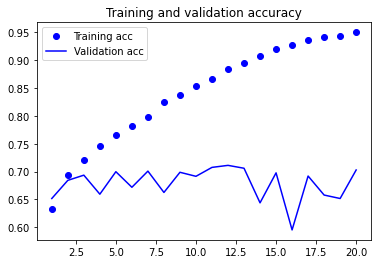

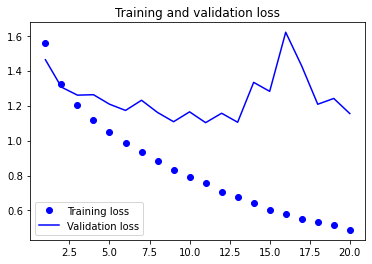

In [ ]:
plot_graphs(history)

In [ ]:
convnet_model.evaluate(x_test, y_test)

101/101 [==============================] - 7s 73ms/step - loss: 1.1346 - acc: 0.7098


[1.134647250175476, 0.7097674608230591]

In [ ]:
pred=convnet_model.predict(x_test)
pred=np.argmax(pred, axis=1)
ytest=np.argmax(y_test, axis=1)
# reduce to 1d array
print(classification_report(pred, ytest, target_names=['neg', 'n', 'pos']))

              precision    recall  f1-score   support

         neg       0.75      0.68      0.71      1191
           n       0.55      0.71      0.62       834
         pos       0.84      0.74      0.78      1200

    accuracy                           0.71      3225
   macro avg       0.71      0.71      0.71      3225
weighted avg       0.73      0.71      0.72      3225



In [ ]:
convnet_model.save('Models/w2v_convnet_model.h5')